# Описание проекта "Принятие решений в бизнесе"

- Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Эти гипотезы необходимо приоритизаровать. 
- Также у нас есть данные по проводимому A/B-тесту. Проанализируем результаты — будем изучать конверсию (среднее количество заказов на пользователя) и средний чек по заказам в двух группах пользователей.

# Описание данных

## Данные для первой части
### Файл `/datasets/hypothesis.csv`. 
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
## Данные для второй части
### Файл `/datasets/orders.csv` 
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.
### Файл `/datasets/visitors.csv`. 
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

# Оглавление
1. [Загрузка данных](#start)
2. [Анализ данных](#eda)
3. [Приоритизация гипотез](#hypoteses)
4. [Анализ A/B теста](#ab_test)
5. [Выводы и рекомендации](#conclusion)

<a id="start"></a>
# Загрузка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# зададим стиль по-умолчанию для графиков
plt.style.use('ggplot')

In [2]:
# Избавиться от экспоненты
pd.options.display.float_format = '{:,.1f}'.format

In [3]:
# загружаем CSV-файлы с данными и сохраняем их в датафреймы
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    hypothesis = pd.read_csv('../datasets/hypothesis.csv')
    orders = pd.read_csv('../datasets/orders.csv')
    visitors = pd.read_csv('../datasets/visitors.csv')

<a id="eda"></a>
# Предобработка и исследовательский анализ данных

In [4]:
# Зададим функцию для исследовательского анализа данных
def perform_eda(dataframe):
    """
    Производит исследовательский анализ данных (EDA) переданного датафрейма.
    
    Параметры:
    dataframe (pd.DataFrame): DataFrame для анализа.
    """
    
    # Основная информация
    print("Основная информация:")
    display(dataframe.head())
    display(dataframe.info())
    
    # Сводная статистика для числовых столбцов
    print("\nСводная статистика для числовых столбцов:")
    display(dataframe.describe())
    
    # Сводная статистика для категориальных столбцов
    print("\nСводная статистика для категориальных столбцов:")
    display(dataframe.describe(include='object'))
    
    # Пропуски
    print("\nПропущенные значения:")
    missing_values = dataframe.isnull().sum()
    missing_percentage = (missing_values / len(dataframe)) * 100
    missing_info = pd.DataFrame({'Пропуски': missing_values, 'Доля': missing_percentage})
    display(missing_info)
    
    # Дубликаты
    print("\nДубликаты:")
    duplicated_rows = dataframe[dataframe.duplicated()]
    display(duplicated_rows)
    
    # Типы данных
    print("\nТипы данных:")
    display(dataframe.dtypes)
    
    # Уникальные значения категориальных столбцов
    print("\nУникальные значения категориальных столбцов:")
    categorical_columns = dataframe.select_dtypes(include='object').columns
    for column in categorical_columns:
        unique_counts = dataframe[column].value_counts()
        if len(unique_counts) <= 10:
            print(f"{column}:\n")
            display(unique_counts)
    
    # Визуализация
    print("\nВизуализация:")
    numerical_columns = dataframe.select_dtypes(include=np.number).columns
    for column in numerical_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(dataframe[column], kde=True)
        plt.title(f'Распределение {column}')
        plt.show()

Основная информация:


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None


Сводная статистика для числовых столбцов:


,Reach,Impact,Confidence,Efforts
count,9.0,9.0,9.0,9.0
mean,4.8,4.8,5.6,4.9
std,3.2,3.2,3.0,2.8
min,1.0,1.0,1.0,1.0
25%,3.0,3.0,3.0,3.0
50%,3.0,3.0,7.0,5.0
75%,8.0,7.0,8.0,6.0
max,10.0,10.0,9.0,10.0



Сводная статистика для категориальных столбцов:


,Hypothesis
count,9
unique,9
top,"Изменить структура категорий, что увеличит кон..."
freq,1



Пропущенные значения:


,Пропуски,Доля
Hypothesis,0,0.0
Reach,0,0.0
Impact,0,0.0
Confidence,0,0.0
Efforts,0,0.0



Дубликаты:


,Hypothesis,Reach,Impact,Confidence,Efforts



Типы данных:


Hypothesis    object
Reach          int64
Impact         int64
Confidence     int64
Efforts        int64
dtype: object


Уникальные значения категориальных столбцов:
Hypothesis:



Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар             1
Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию            1
Запустить собственную службу доставки, что сократит срок доставки заказов                                       1
Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов                        1
Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей                                1
Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа    1
Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок                1
Запустить акцию, дающую скидку на товар в день рождения                                                         1
Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пол


Визуализация:


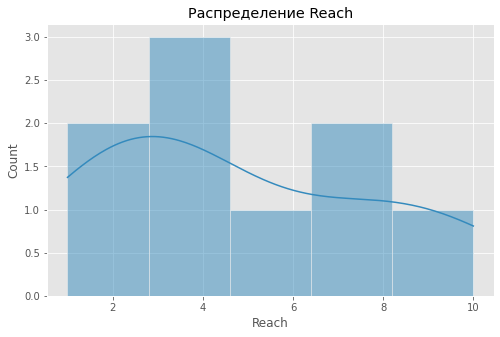

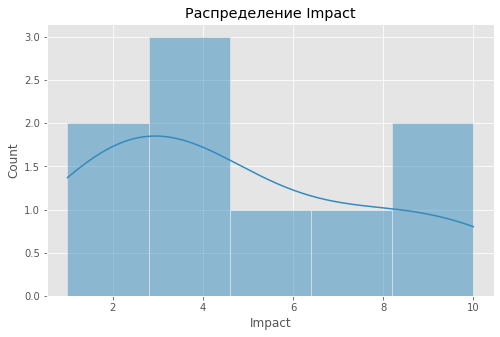

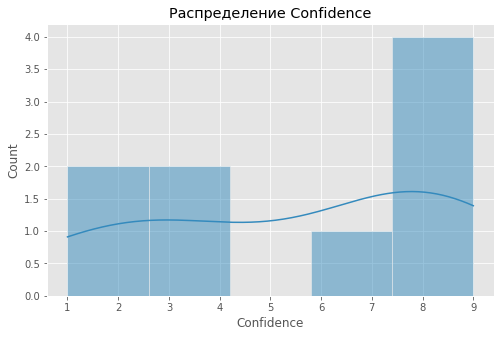

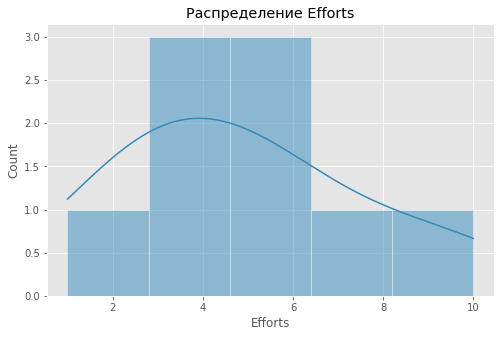

In [5]:
# исследуем первый датафрейм - гипотезы
perform_eda(hypothesis)

In [6]:
# выведем названия гипотез полностью
pd.options.display.max_colwidth = 120
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В датафрейме всего 9 строк, они описывают гипотезы и назначенные параметры для рассчёта приоритетов.
Дубликатов и пропусков нет, типы данных корректны

In [7]:
# поменяем названия столбцов
hypothesis = hypothesis.rename(columns=str.lower)

Основная информация:


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None


Сводная статистика для числовых столбцов:


,visitors
count,62.0
mean,607.3
std,114.4
min,361.0
25%,534.0
50%,624.5
75%,710.5
max,770.0



Сводная статистика для категориальных столбцов:


,date,group
count,62,62
unique,31,2
top,2019-08-07,A
freq,2,31



Пропущенные значения:


,Пропуски,Доля
date,0,0.0
group,0,0.0
visitors,0,0.0



Дубликаты:


,date,group,visitors



Типы данных:


date        object
group       object
visitors     int64
dtype: object


Уникальные значения категориальных столбцов:
group:



A    31
B    31
Name: group, dtype: int64


Визуализация:


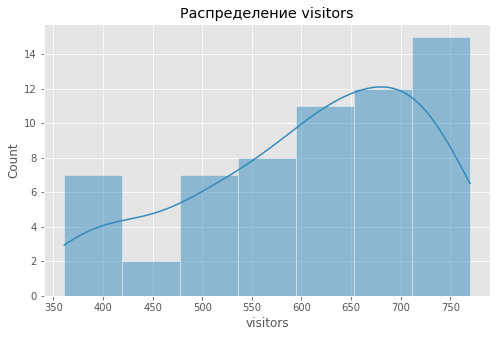

In [8]:
# изучим второй датасет - посетители
perform_eda(visitors)

В датафрейме 62 строки, по 31 в двух группах, 31 уникальная дата.
Пропусков и дубликатов нет, дату приведём к нужному типу данных

In [9]:
# Приведём столбец `date` к типу даты pandas.
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

Основная информация:


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None


Сводная статистика для числовых столбцов:


,transactionId,visitorId,revenue
count,"1,197.0","1,197.0","1,197.0"
mean,"2,155,621,385.5","2,165,960,143.1","8,348.0"
std,"1,229,084,904.8","1,236,014,192.1","39,191.1"
min,"1,062,393.0","5,114,589.0",50.0
25%,"1,166,775,572.0","1,111,826,046.0","1,220.0"
50%,"2,145,193,898.0","2,217,984,702.0","2,978.0"
75%,"3,237,740,112.0","3,177,606,451.0","8,290.0"
max,"4,293,855,558.0","4,283,872,382.0","1,294,500.0"



Сводная статистика для категориальных столбцов:


,date,group
count,1197,1197
unique,31,2
top,2019-08-05,B
freq,48,640



Пропущенные значения:


,Пропуски,Доля
transactionId,0,0.0
visitorId,0,0.0
date,0,0.0
revenue,0,0.0
group,0,0.0



Дубликаты:


,transactionId,visitorId,date,revenue,group



Типы данных:


transactionId     int64
visitorId         int64
date             object
revenue           int64
group            object
dtype: object


Уникальные значения категориальных столбцов:
group:



B    640
A    557
Name: group, dtype: int64


Визуализация:


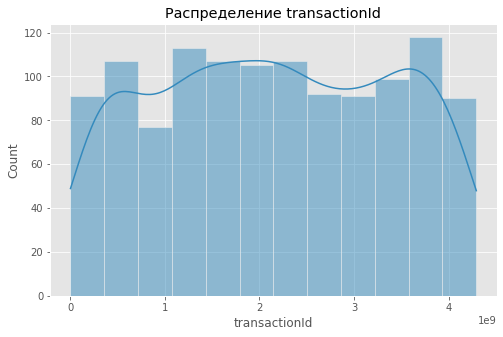

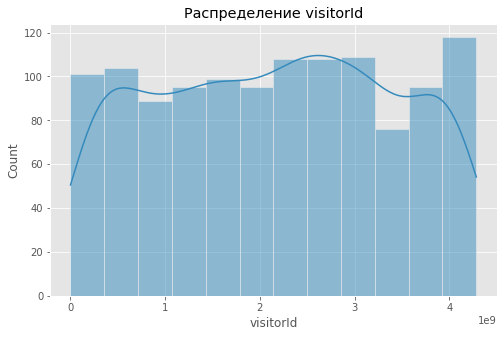

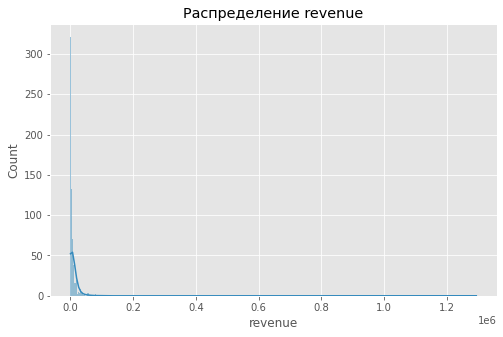

In [10]:
# изучим датасет с заказами
perform_eda(orders)

В датафрейме 1197 строк, 31 уникальная дата, 2 группы
В группе B транзакций больше, чем в группе А.
График распределения выручки показывает наличие выбросов (слишком больших значений)
Пропусков и дубликатов нет, дату приведём к нужному типу данных

In [11]:
# посмотрим на количество посетителей в группах
orders.groupby(by='group')['visitorId'].nunique()

group
A    503
B    586
Name: visitorId, dtype: int64

Количество пользователей в выборках значительно различается

In [12]:
# Приведём столбец `date` к типу даты pandas.
orders['date'] = pd.to_datetime(orders['date'])
orders.dtypes

transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object

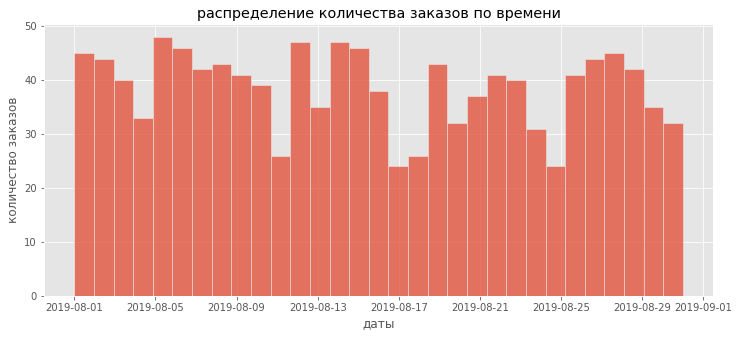

In [13]:
# проанализируем даты начала и окончания теста
plt.figure(figsize=(12,5))

sns.histplot(orders['date'], bins=31)

plt.title('распределение количества заказов по времени')
plt.xlabel('даты')
plt.ylabel('количество заказов')
plt.show()


In [14]:
print(f"Дата начала теста: {orders['date'].min()}, дата окончания теста: {orders['date'].max()}")

Дата начала теста: 2019-08-01 00:00:00, дата окончания теста: 2019-08-31 00:00:00


In [15]:
# проанализируем вероятность попадания пользователей в обе группы - по таблице с заказами.
mask = orders.groupby('visitorId')['group'].agg('nunique') > 1
doubles = mask[mask == True]
orders[orders['visitorId'].isin(doubles.index)].sort_values(by='visitorId')

,transactionId,visitorId,date,revenue,group
703,4293855558,8300375,2019-08-07,1790,A
71,3679129301,8300375,2019-08-01,10510,B
823,2971973105,199603092,2019-08-27,2790,A
246,437656952,199603092,2019-08-02,3488,B
26,2223239646,199603092,2019-08-15,3488,A
...,...,...,...,...,...
187,2048878902,4256040402,2019-08-17,1550,A
114,1120327437,4256040402,2019-08-01,5800,A
60,1421016313,4256040402,2019-08-16,56650,B
662,1811671147,4266935830,2019-08-29,78990,A


Нашли заказы пользователей, которые попали в обе группы. Для анализа не будем далее использовать их.

In [16]:
orders = orders[~orders['visitorId'].isin(doubles.index)]
orders.shape

(1016, 5)

<a id="hypoteses"></a>
# Приоритизация гипотез

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

- Применим фреймворк `ICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.



In [17]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'])

display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


- Применим фреймворк `RICE` для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [18]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts'])

display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [19]:
# вывод всей таблицы с результатами для сравнения
hypothesis

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.0,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.0,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.1,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.0,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.3,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.0,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2


## Предварительные итоги


При применении RICE вместо ICE самыми приоритетными становятся гипотезы "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа", которые в ICE были на 3 и 5м месте соответственно. Гипотеза, которая была самой приоритетной в ICE - "Запустить акцию, дающую скидку на товар в день рождения", спустилась на 5е место.

Это можно объяснить тем, что у гипотез "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" и "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа" высокое значение Reach, то есть они влияют почти на всех пользователей. При этом ICE ранг у них также не маленький. У гипотезы "Запустить акцию, дающую скидку на товар в день рождения" Reach наоборот самый малый, то есть она повлияет на малое количество пользователей.

<a id="ab_test"></a>

# Анализ A/B теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`.

Проанализируем A/B-тест:
- Построим график кумулятивной выручки по группам.

In [20]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}
    ), axis=1
).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg(
        {'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}
    ), axis=1
).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head(5))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [21]:
# совпадают ли минимальная и максимальная даты в этом датафрейме 
# с минимальной и максимальной датой в исходных данных
print(f"Дата начала: {cumulativeData['date'].min()}, дата окончания: {cumulativeData['date'].max()}")

Дата начала: 2019-08-01 00:00:00, дата окончания: 2019-08-31 00:00:00


Даты совпадают

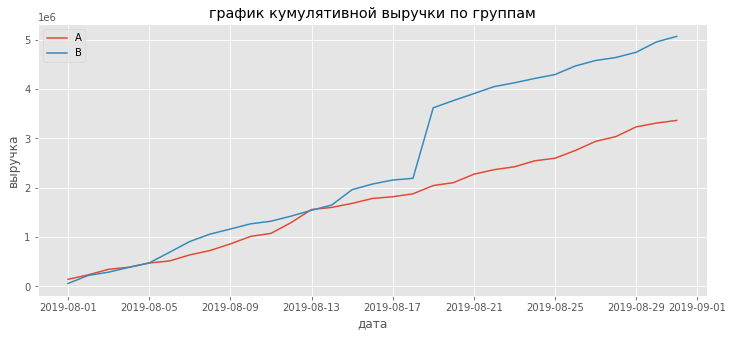

In [22]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

plt.title('график кумулятивной выручки по группам')
plt.xlabel('дата')
plt.ylabel('выручка')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. 
Однако график выручки группы B резко растёт после 18го августа. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем ниже.


- Построим график кумулятивного среднего чека по группам.

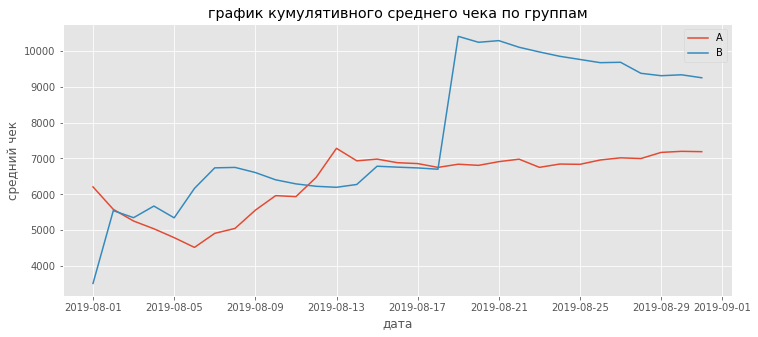

In [23]:
plt.figure(figsize=(12,5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()

plt.title('график кумулятивного среднего чека по группам')
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.show()

Средний чек тоже становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. В группу B попали крупные заказы (резкий всплеск на графике). Ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

- Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

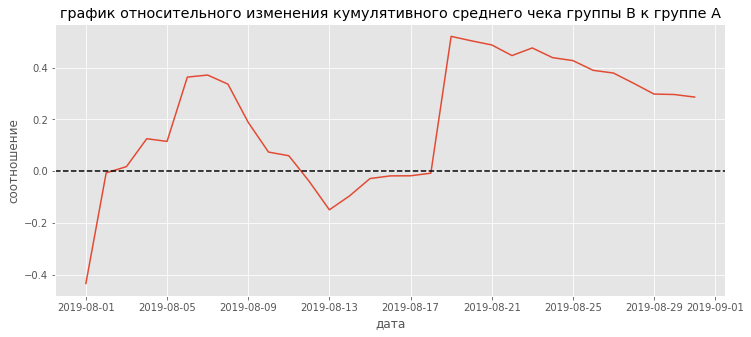

In [24]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.title('график относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')
plt.ylabel('соотношение')
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Сказывается влияние крупных заказов и выбросов. Найдём их позже.

- Построим график кумулятивного среднего количества заказов на посетителя по группам.

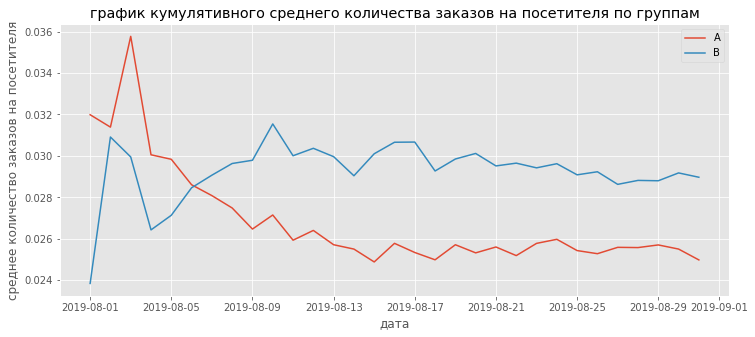

In [25]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12,5))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.title('график кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('дата')
plt.ylabel('среднее количество заказов на посетителя')
plt.show()

Группы колебались, конверсия группы B вырвалась вперёд и зафиксировалась, конверсия группы A просела и также зафиксировалась.

- Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

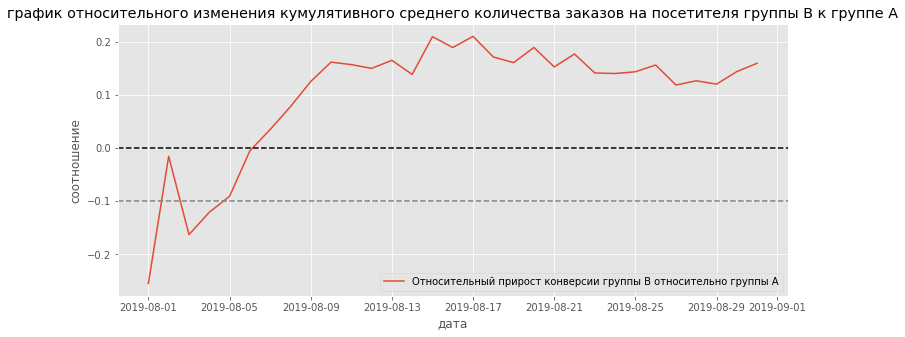

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')

plt.title('график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('дата')
plt.ylabel('соотношение')
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. 
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя. Впрочем, сперва стоит проанализировать аномалии, возможно, они изменят картину. 

- Построим точечный график количества заказов по пользователям. 

In [27]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)

ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10)) 

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


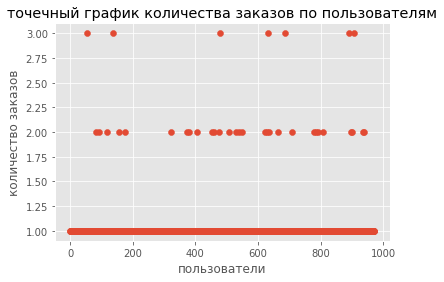

In [28]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

plt.title('точечный график количества заказов по пользователям')
plt.xlabel('пользователи')
plt.ylabel('количество заказов')
plt.show()

много пользователей с 2-3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет. 

- Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. 

In [29]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 5% пользователей оформляли больше чем 2 заказа. И 10% пользователей заказывали более трёх раз. 
Разумно выбрать 3 или 4 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

- Построим точечный график стоимостей заказов. 

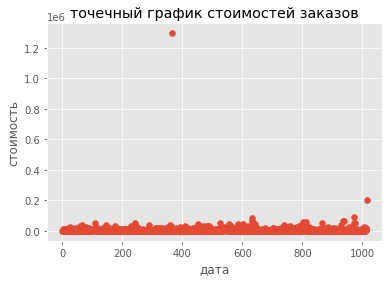

In [30]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])

plt.title('точечный график стоимостей заказов')
plt.xlabel('дата')
plt.ylabel('стоимость')
plt.show()

Всё, как предполагали: есть немного дорогих заказов. По графику можно выбрать границу аномальных заказов 20 000 рублей. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. 

- Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [31]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей.
Примем за аномальных пользователей тех, кто совершил совершил заказ дороже 30 000 рублей. Так мы уберём от 1% до 5% пользователей с дорогими заказами. 

- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

In [32]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p-value: 0.011
0.160


Первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8% — второе число в выводе.

По «сырым» данным есть различия в среднем числе заказов групп A и B

- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 
А ещё найдём относительные различия в среднем чеке между группами

In [34]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A.

- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

найденные в прошлых пунктах 95-й и 99-й перцентили средних чеков равны 28000 и 58233 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя.
Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 30 000 рублей. Так мы уберём от 1% до 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 30 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. 
Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [35]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

1099    148427295
928     204675465
33      249864742
684     358944393
648     382846391
Name: visitorId, dtype: int64
49


Всего 68 аномальных пользователей. 


- Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [37]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.010
0.187


Результаты по среднему количеству заказов практически не изменились. Произошло ли что-нибудь с результатами по среднему чеку?

In [38]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "p-value: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.741
p-value: -0.027


P-value уменьшился незначительно,  разница между сегментами сократилась с 26% до 2.3%.

<a id="conclusion"></a>
# Выводы

Имеющиеся факты:
- Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A, однако конкретное значение ещё не установилось
- График различия среднего чека говорит о том, что результаты группы B ухудшаются день ото дня, и на них влияют аномальные заказы
- В группе B значительно больше пользователей, чем в группе A

Исходя из обнаруженных фактов, тест следует продолжить, если есть возможность скорректировать баланс между количеством пользователей в группах. 
Сейчас данные говорят о том, что в группе B средний чек может не отличаться от группы A, но конверсия (среднее количество числа заказов) - выше. Однако и пользователей в группе B сейчас больше, чем в группе A. Без корректировки набора в группы выводы делать преждевременно.